In [1]:
# ============================================================================
# 绘制 FLOPs vs GT Rank 散点图
# 目标：可视化 FLOPs 与真实性能排名的相关性
# ============================================================================

import sys
import os
import random
import importlib.util
from pathlib import Path
import warnings
import argparse
import itertools

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata, spearmanr
from tqdm import tqdm
from fvcore.nn import FlopCountAnalysis

# 忽略警告
warnings.filterwarnings("ignore")

# ============================================================================
# 配置参数（可修改）
# ============================================================================

SEARCH_SPACES = ["micro", "macro"]  # 搜索空间列表
TASKS = ["autoencoder", "segmentsemantic", "normal"]  # 任务列表
NUM_SAMPLES = 10  # 每个任务采样的架构数量
SEED = 42  # 随机种子
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # 设备

# ============================================================================
# 路径设置
# ============================================================================

CURRENT_DIR = Path.cwd()  # 当前目录
ROOT_DIR = CURRENT_DIR.parent if CURRENT_DIR.name == "proxy_TransNAS" else CURRENT_DIR  # MCUFlowNet 根目录
NASLIB_ROOT = ROOT_DIR / "NASLib"  # NASLib 路径
sys.path.insert(0, str(NASLIB_ROOT))

# ============================================================================
# 加载 TransNAS-Bench-101 API
# ============================================================================

_GLOBAL_TRANSNASBENCH_API = None  # 全局缓存

def load_transbench_classes():
    """动态加载 transbench101 的搜索空间类"""
    graph_path = NASLIB_ROOT / "naslib" / "search_spaces" / "transbench101" / "graph.py"
    spec = importlib.util.spec_from_file_location("transbench_graph", graph_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module.TransBench101SearchSpaceMicro, module.TransBench101SearchSpaceMacro, module

def load_transbench_api(task: str):
    """加载 TransNASBenchAPI（全局缓存）"""
    global _GLOBAL_TRANSNASBENCH_API
    
    api_path = NASLIB_ROOT / "naslib" / "search_spaces" / "transbench101" / "api.py"
    spec = importlib.util.spec_from_file_location("transbench_api", api_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    TransNASBenchAPI = module.TransNASBenchAPI
    
    if _GLOBAL_TRANSNASBENCH_API is None:
        candidate = NASLIB_ROOT / "naslib" / "data" / "transnas-bench_v10141024.pth"
        if not candidate.exists():
            candidate = Path("D:/Dataset/MCUFlowNet/NASLib/naslib/data/transnas-bench_v10141024.pth")
        assert candidate.exists(), f"缺少 transnas-bench_v10141024.pth"
        _GLOBAL_TRANSNASBENCH_API = TransNASBenchAPI(str(candidate))
    
    return {"api": _GLOBAL_TRANSNASBENCH_API, "task": task}

# ============================================================================
# 采样架构
# ============================================================================

def sample_architectures(ss, dataset_api, num_samples: int, seed: int):
    """采样不重复的架构，返回架构标识符列表"""
    random.seed(seed)
    torch.manual_seed(seed)
    
    arch_identifiers = []
    seen_hashes = set()
    
    max_attempts = num_samples * 10
    attempts = 0
    
    print(f"  正在采样 {num_samples} 个架构...", end="", flush=True)
    
    while len(arch_identifiers) < num_samples and attempts < max_attempts:
        attempts += 1
        temp_graph = ss.clone()
        temp_graph.sample_random_architecture(dataset_api=dataset_api)
        
        try:
            arch_hash = tuple(temp_graph.get_hash())
        except Exception:
            del temp_graph
            continue
        
        if arch_hash in seen_hashes:
            del temp_graph
            continue
        
        seen_hashes.add(arch_hash)
        arch_identifiers.append(arch_hash)
        del temp_graph
    
    print(f" 完成（{len(arch_identifiers)} 个）")
    return arch_identifiers

# ============================================================================
# 数据加载相关
# ============================================================================

from naslib import utils
get_train_val_loaders = utils.get_train_val_loaders

def build_config(data_root: Path, dataset: str, batch_size: int, seed: int):
    """构造配置对象，用于 NASLib 的数据加载器"""
    search_cfg = argparse.Namespace(
        seed=seed,
        batch_size=batch_size,
        train_portion=0.7,
    )
    config = argparse.Namespace(
        data=str(data_root),
        dataset=dataset,
        search=search_cfg,
    )
    return config

def make_train_loader(task: str, data_root: Path, batch_size: int, seed: int):
    """生成指定任务的训练 DataLoader"""
    config = build_config(data_root, task, batch_size, seed)
    train_loader, _, _, _, _ = get_train_val_loaders(config)
    return train_loader

# ============================================================================
# 计算 FLOPs
# ============================================================================

def compute_flops_simple(model, train_batches, device):
    """
    计算单个模型的 FLOPs（从真实数据中获取输入张量）
    
    参数：
        model: PyTorch 模型
        train_batches: 真实数据的 batch 列表
        device: 计算设备
    """
    model.eval()
    model.to(device)
    
    # 从真实数据中获取输入张量
    data, _ = train_batches[0]
    input_tensor = data[:1].to(device)  # 只用一个样本即可
    
    try:
        with torch.no_grad():
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message=".*unsupported.*")
                warnings.filterwarnings("ignore", message=".*Unsupported.*")
                warnings.filterwarnings("ignore", message=".*were never called.*")
                flop_analyzer = FlopCountAnalysis(model, input_tensor)
                flop_analyzer.unsupported_ops_warnings(False)
                flop_analyzer.uncalled_modules_warnings(False)
                total_flops = flop_analyzer.total()
        return float(total_flops)
    except Exception as e:
        print(f"    FLOPs 计算失败: {e}")
        return 0.0

# ============================================================================
# 主评估函数
# ============================================================================

def evaluate_flops_correlation(search_space: str, task: str, num_samples: int, seed: int):
    """评估单个搜索空间+任务的 FLOPs 与 GT 相关性"""
    print(f"\n{'='*60}")
    print(f"搜索空间: {search_space.upper()} | 任务: {task}")
    print(f"{'='*60}")
    
    # 加载类和 API
    TransBench101SearchSpaceMicro, TransBench101SearchSpaceMacro, graph_module = load_transbench_classes()
    Metric = graph_module.Metric
    dataset_api = load_transbench_api(task)
    
    # 创建搜索空间
    if search_space == "micro":
        if task == "segmentsemantic":
            ss = TransBench101SearchSpaceMicro(dataset=task, create_graph=True, n_classes=17)
        else:
            ss = TransBench101SearchSpaceMicro(dataset=task, create_graph=True)
    else:
        ss = TransBench101SearchSpaceMacro(dataset=task, create_graph=True)
    
    # 创建真实数据加载器（用于 FLOPs 计算）
    data_root = NASLIB_ROOT / "naslib" / "data"
    batch_size = 1  # FLOPs 计算只需要一个样本，batch_size 不重要
    train_loader = make_train_loader(task, data_root, batch_size, seed)
    train_batches = list(itertools.islice(iter(train_loader), 1))  # 只取一个 batch
    
    print(f"  数据加载完成，输入形状: {train_batches[0][0].shape}")
    
    # 采样架构
    arch_identifiers = sample_architectures(ss, dataset_api, num_samples, seed)
    
    # 存储结果
    flops_list = []
    gt_list = []
    
    # 逐个评估
    for i, arch_identifier in enumerate(tqdm(arch_identifiers, desc="  计算 FLOPs", unit="arch")):
        # 重建架构
        graph = ss.clone()
        graph.set_op_indices(list(arch_identifier))
        
        # 查询 GT
        try:
            gt = graph.query(metric=Metric.VAL_ACCURACY, dataset=task, dataset_api=dataset_api)
        except Exception as e:
            print(f"    GT 查询失败 (arch {i}): {e}")
            del graph
            continue
        
        # 实例化模型并计算 FLOPs
        try:
            graph.parse()
            model = graph.to(DEVICE)
            flops = compute_flops_simple(model, train_batches, DEVICE)
            
            if flops > 0:  # 只记录有效结果
                flops_list.append(flops)
                gt_list.append(gt)
            
            model.cpu()
            del model
        except Exception as e:
            print(f"    模型实例化失败 (arch {i}): {e}")
        
        del graph
        torch.cuda.empty_cache()
    
    print(f"  有效架构数: {len(flops_list)} / {num_samples}")
    
    # 只对 GT 计算排名（FLOPs 保持原始值）
    gt_ranks = rankdata(gt_list, method='ordinal')  # GT 越高越好 → 高值排名高
    
    # 计算原始 FLOPs 与 GT 排名的相关性
    rho, _ = spearmanr(flops_list, gt_ranks)
    
    print(f"  Spearman ρ(FLOPs, GT_rank) = {rho:.4f}")
    
    return {
        "search_space": search_space,
        "task": task,
        "flops": np.array(flops_list),  # 原始 FLOPs 值
        "gt": np.array(gt_list),
        "gt_ranks": gt_ranks,  # GT 排名
        "spearman": rho,  # FLOPs vs GT_rank 的相关性
        "n_valid": len(flops_list),
    }

print("✓ 代码加载完成！")
print(f"  采样数量: {NUM_SAMPLES}")
print(f"  设备: {DEVICE}")


✓ 代码加载完成！
  采样数量: 10
  设备: cuda


In [2]:
# ============================================================================
# 运行评估并收集结果
# ============================================================================

results = {}

for search_space in SEARCH_SPACES:
    for task in TASKS:
        key = f"{search_space}_{task}"
        result = evaluate_flops_correlation(search_space, task, NUM_SAMPLES, SEED)
        results[key] = result

print("\n" + "="*60)
print("✓ 所有评估完成！")
print("="*60)



搜索空间: MICRO | 任务: autoencoder
  数据加载完成，输入形状: torch.Size([1, 3, 256, 256])
  正在采样 10 个架构... 完成（10 个）


  计算 FLOPs: 100%|██████████| 10/10 [00:04<00:00,  2.30arch/s]

  有效架构数: 10 / 10
  Spearman ρ(FLOPs, GT_rank) = -0.3333

搜索空间: MICRO | 任务: segmentsemantic
  数据加载完成，输入形状: torch.Size([1, 3, 256, 256])
  正在采样 10 个架构...

 完成（10 个）


  计算 FLOPs: 100%|██████████| 10/10 [00:04<00:00,  2.38arch/s]

  有效架构数: 10 / 10
  Spearman ρ(FLOPs, GT_rank) = 0.1152

搜索空间: MICRO | 任务: normal
  数据加载完成，输入形状: torch.Size([1, 3, 256, 256])
  正在采样 10 个架构...

 完成（10 个）


  计算 FLOPs: 100%|██████████| 10/10 [00:04<00:00,  2.32arch/s]

  有效架构数: 10 / 10
  Spearman ρ(FLOPs, GT_rank) = -0.3697

搜索空间: MACRO | 任务: autoencoder
  数据加载完成，输入形状: torch.Size([1, 3, 256, 256])
  正在采样 10 个架构...

 完成（10 个）


  计算 FLOPs: 100%|██████████| 10/10 [00:04<00:00,  2.30arch/s]

  有效架构数: 10 / 10
  Spearman ρ(FLOPs, GT_rank) = 0.8303

搜索空间: MACRO | 任务: segmentsemantic
  数据加载完成，输入形状: torch.Size([1, 3, 256, 256])
  正在采样 10 个架构...

 完成（10 个）


  计算 FLOPs: 100%|██████████| 10/10 [00:02<00:00,  3.47arch/s]

  有效架构数: 10 / 10
  Spearman ρ(FLOPs, GT_rank) = 0.6970

搜索空间: MACRO | 任务: normal
  数据加载完成，输入形状: torch.Size([1, 3, 256, 256])
  正在采样 10 个架构...

 完成（10 个）


  计算 FLOPs: 100%|██████████| 10/10 [00:05<00:00,  1.87arch/s]

  有效架构数: 10 / 10
  Spearman ρ(FLOPs, GT_rank) = 0.6121

✓ 所有评估完成！


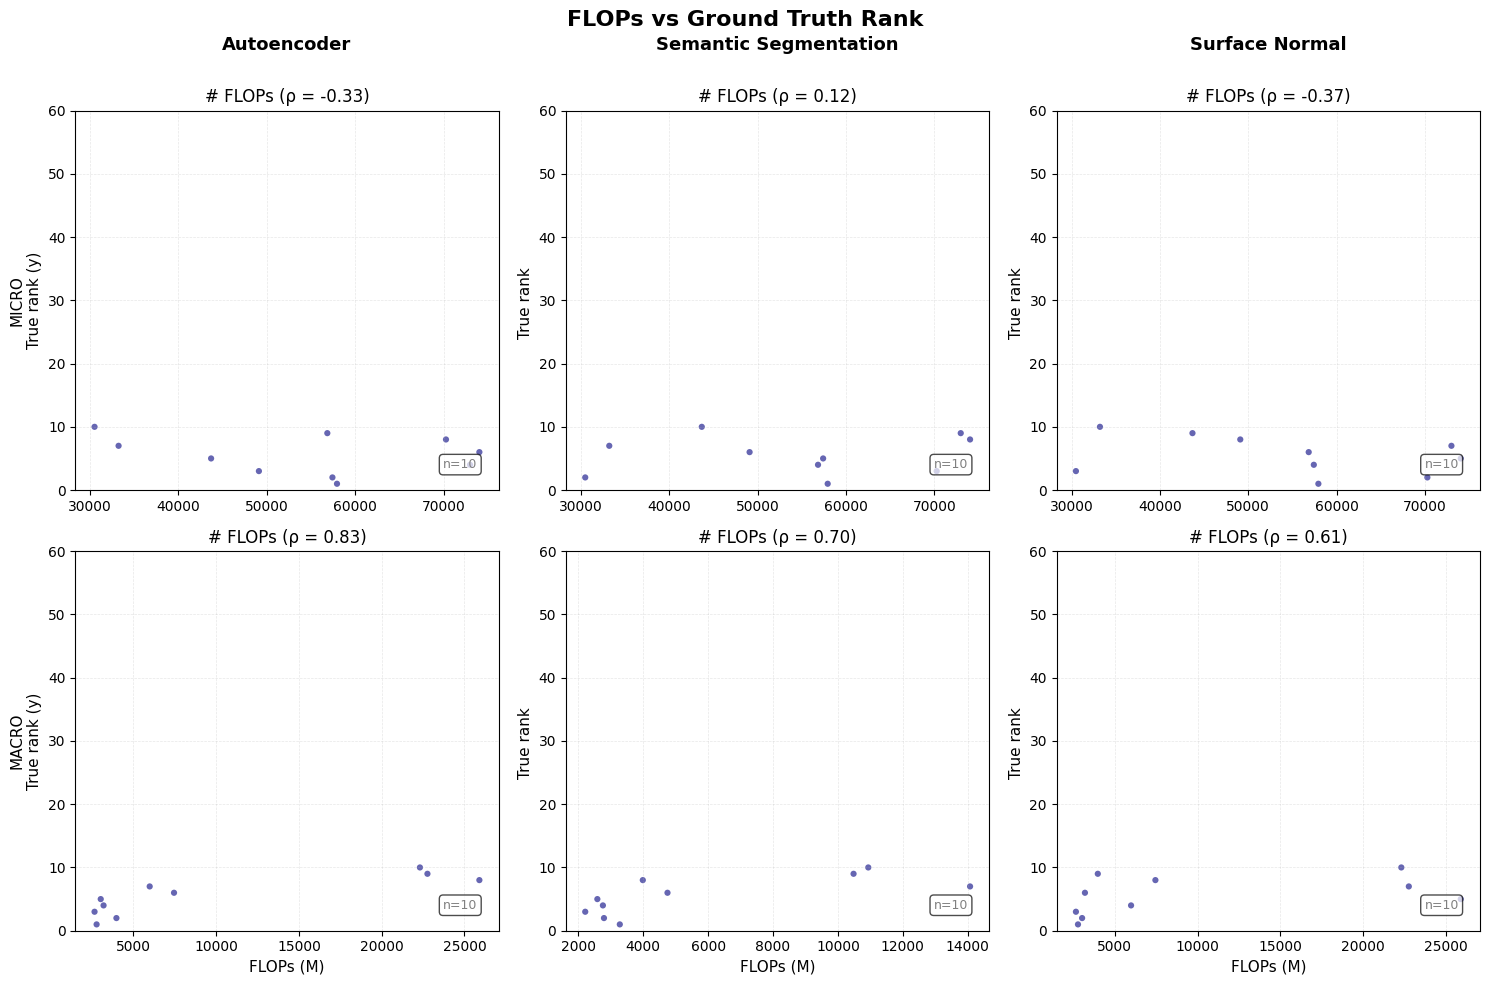


✓ 绘图完成！


In [ ]:
# ============================================================================
# 绘制散点图（2x3 布局：2个搜索空间 x 3个任务）
# x 轴：原始 FLOPs 值（不是排名）
# y 轴：GT 排名
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("FLOPs vs Ground Truth Rank", fontsize=16, fontweight='bold')

# 任务名称映射（用于标题）
task_names = {
    "autoencoder": "Autoencoder",
    "segmentsemantic": "Semantic Segmentation",
    "normal": "Surface Normal",
}

for i, search_space in enumerate(SEARCH_SPACES):
    for j, task in enumerate(TASKS):
        ax = axes[i, j]
        key = f"{search_space}_{task}"
        
        if key in results:
            res = results[key]
            # 绘制散点图：x = 原始 FLOPs，y = GT 排名
            ax.scatter(res['flops'], res['gt_ranks'], 
                      alpha=0.6, s=20, color='navy', edgecolors='none')
            
            # 设置标题（显示相关系数）
            title = f"# FLOPs (ρ = {res['spearman']:.2f})"
            ax.set_title(title, fontsize=12)
            
            # 设置坐标轴标签
            if j == 0:  # 最左列
                ax.set_ylabel(f'{search_space.upper()}\nTrue rank (y)', fontsize=11)
            else:
                ax.set_ylabel('True rank ', fontsize=11)
            
            if i == 1:  # 最下行
                ax.set_xlabel('FLOPs (M)', fontsize=11)
            
            # 添加任务名称作为子标题
            if i == 0:  # 第一行添加任务名
                ax.text(0.5, 1.15, task_names[task], 
                       transform=ax.transAxes, 
                       ha='center', va='bottom',
                       fontsize=13, fontweight='bold')
            
            # 设置网格
            ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
            
            # 设置坐标轴范围（x 轴根据 FLOPs 范围自动调整）
            flops_min = res['flops'].min()
            flops_max = res['flops'].max()
            flops_margin = (flops_max - flops_min) * 0.05
            ax.set_xlim(flops_min - flops_margin, flops_max + flops_margin)
            
            rank_max = res['gt_ranks'].max()
            ax.set_ylim(0, rank_max + 50)
            
            # 添加有效样本数标注
            ax.text(0.95, 0.05, f'n={res["n_valid"]}', 
                   transform=ax.transAxes,
                   ha='right', va='bottom',
                   fontsize=9, color='gray',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n✓ 绘图完成！")


In [7]:
# ============================================================================
# 打印汇总统计信息
# ============================================================================

print("\n" + "="*70)
print("FLOPs 与 GT Rank 相关性汇总")
print("="*70)

for search_space in SEARCH_SPACES:
    print(f"\n【{search_space.upper()} 搜索空间】")
    print("-" * 70)
    
    for task in TASKS:
        key = f"{search_space}_{task}"
        if key in results:
            res = results[key]
            task_display = task_names[task]
            
            # 计算 FLOPs 统计信息
            flops_mean = res['flops'].mean()
            flops_std = res['flops'].std()
            flops_min = res['flops'].min()
            flops_max = res['flops'].max()
            flops_median = np.median(res['flops'])
            
            # 计算 GT 统计信息
            gt_mean = res['gt'].mean()
            gt_std = res['gt'].std()
            gt_min = res['gt'].min()
            gt_max = res['gt'].max()
            
            print(f"\n  {task_display:25} (n={res['n_valid']})")
            print(f"    Spearman ρ(FLOPs, GT_rank): {res['spearman']:>8.4f}")
            print(f"    FLOPs 范围:      {flops_min:>12.2e} ~ {flops_max:>12.2e}")
            print(f"    FLOPs 均值:      {flops_mean:>12.2e} (σ={flops_std:>12.2e})")
            print(f"    FLOPs 中位数:    {flops_median:>12.2e}")
            print(f"    GT 范围:         {gt_min:>12.4f} ~ {gt_max:>12.4f}")
            print(f"    GT 均值:         {gt_mean:>12.4f} (σ={gt_std:>12.4f})")

print("\n" + "="*70)
print("✓ 统计完成！")
print("="*70)



FLOPs 与 GT Rank 相关性汇总

【MICRO 搜索空间】
----------------------------------------------------------------------

  Autoencoder               (n=10)
    Spearman ρ(FLOPs, GT_rank):  -0.3333
    FLOPs 范围:          3.05e+04 ~     7.40e+04
    FLOPs 均值:          5.46e+04 (σ=    1.47e+04)
    FLOPs 中位数:        5.71e+04
    GT 范围:               0.2459 ~       0.5263
    GT 均值:               0.4482 (σ=      0.0844)

  Semantic Segmentation     (n=10)
    Spearman ρ(FLOPs, GT_rank):   0.1152
    FLOPs 范围:          3.05e+04 ~     7.41e+04
    FLOPs 均值:          5.46e+04 (σ=    1.47e+04)
    FLOPs 中位数:        5.71e+04
    GT 范围:              91.7476 ~      94.4909
    GT 均值:              93.7573 (σ=      0.8636)

  Surface Normal            (n=10)
    Spearman ρ(FLOPs, GT_rank):  -0.3697
    FLOPs 范围:          3.05e+04 ~     7.40e+04
    FLOPs 均值:          5.46e+04 (σ=    1.47e+04)
    FLOPs 中位数:        5.71e+04
    GT 范围:               0.3865 ~       0.5731
    GT 均值:               0.5228 (σ=      

In [ ]:
# ============================================================================
# （可选）保存结果到文件
# ============================================================================

import pickle
from datetime import datetime

# 创建保存目录
save_dir = Path("flops_analysis_results")
save_dir.mkdir(exist_ok=True)

# 保存结果
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = save_dir / f"flops_results_{timestamp}.pkl"

with open(save_path, 'wb') as f:
    pickle.dump(results, f)

print(f"✓ 结果已保存到: {save_path}")

# 保存图片
fig_path = save_dir / f"flops_scatter_{timestamp}.png"
fig.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ 图片已保存到: {fig_path}")

# ============================================================================
# 使用说明汇总
# ============================================================================
# 
# 本 Notebook 分析：原始 FLOPs 值 vs GT 排名
# 
# 关键点：
# - x 轴：原始 FLOPs 值（不做任何变换）
# - y 轴：GT 排名（按 GT 值排序）
# - 相关性：Spearman ρ(FLOPs, GT_rank)
#   * 正相关 → 高 FLOPs 对应高性能
#   * 负相关 → 高 FLOPs 对应低性能
#   * 无相关 → FLOPs 与性能无关
# 
# 与参考图的对应：
# - 参考图是 "# Params vs True rank"
# - 本图是 "FLOPs vs True rank"
# - 都是观察架构复杂度指标与性能排名的关系
# ============================================================================
